In [1]:
# -------------------------------------------------------- Imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


pd.options.display.max_rows = 1008
pd.options.display.max_columns = 100

In [2]:
# ----------------------------------------------------- SEARCH TERMS ------------------------------------------------
# Search for items in quotes for quick searching - ctrl+f
# For Final Models section - "Final model"
# For Port Scan Linear Regression - "ps_lr"
# For Port Scan Naive Bayes - "ps_bayes"
# For DDoS Linear Regression - "ddos_lr"
# For DDoS Naive Bayes - "ddos_bayes"
# -------------------------------------------------------------------------------------------------------------------

In [3]:
# -------------------------------------------------------- Create Notebook, Path, and inital DFs
notebook_path = os.path.abspath("DataAnalysis.ipynb")
temp = os.path.abspath("Data")

# Load in all of the relevant work sheets
# We chose not to load in the worksheets that had attacks that we did not initially 
#    plan on modeling to save space and computation time

# df1 = pd.read_csv(temp + "\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory = False)
# df2 = pd.read_csv(temp + "\\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory = False)
# df3 = pd.read_csv(temp + "\\Tuesday-WorkingHours.pcap_ISCX.csv", low_memory = False)
# df4 = pd.read_csv(temp + "\\Wednesday-workingHours.pcap_ISCX.csv", low_memory = False)

In [4]:
# -------------------------------------------------------- Remove/Replace irritating values in column names

# df1.columns = df1.columns.str.replace(' ', '')
# df1.columns = df1.columns.str.replace('/s', '_s')

# df2.columns = df2.columns.str.replace(' ', '')
# df2.columns = df2.columns.str.replace('/s', '_s')

# df3.columns = df3.columns.str.replace(' ', '')
# df3.columns = df3.columns.str.replace('/s', '_s')

# df4.columns = df4.columns.str.replace(' ', '')
# df4.columns = df4.columns.str.replace('/s', '_s')

In [5]:
# -------------------------------------------------------- Combine dataframes together
# full_df = df1.append(df2)
# full_df = full_df.append(df3)
# full_df = full_df.append(df4)

In [6]:
# -------------------------------------------------------- NaN Value Analysis
# Sums the NaN values per column
# df1.isna().sum()

# Prints the rows that are NaN values
# df1[df1.isna().any(axis=1)]


# NULL VALUES IN COLUMN "FlowBytes":
#         df1 = 1 / , df2 = 15 / 286467 , df3 = 201 / 445909 , df4 = 1008 / 692703
#         TOTAL NaN ROWS: 1228

In [7]:
# -------------------------------------------------------- Label Counts

# print("DF1")
# print(df1.Label.value_counts())

# print("\nDF2")
# print(df2.Label.value_counts())

# print("\nDF3")
# print(df3.Label.value_counts())

# print("\nDF4")
# print(df4.Label.value_counts())

In [8]:
# -------------------------------------------------------- Drop attack types we are not concerened with

# full_df = full_df[full_df.Label != 'Heartbleed']


#  full_df.dropna(how = 'any', subset=['DestinationPort', 'FlowDuration', 'TotalFwdPackets',
#        'TotalBackwardPackets', 'TotalLengthofFwdPackets',
#        'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
#        'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
#        'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
#        'FlowBytes', 'FlowPackets', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax',
#        'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd', 'FwdIATMax',
#        'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd', 'BwdIATMax',
#        'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags',
#        'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets', 'BwdPackets',
#        'MinPacketLength', 'MaxPacketLength', 'PacketLengthMean',
#        'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount',
#        'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount', 'ACKFlagCount',
#        'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount', 'Down/UpRatio',
#        'AveragePacketSize', 'AvgFwdSegmentSize', 'AvgBwdSegmentSize',
#        'FwdHeaderLength.1', 'FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk',
#        'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk',
#        'BwdAvgBulkRate', 'SubflowFwdPackets', 'SubflowFwdBytes',
#        'SubflowBwdPackets', 'SubflowBwdBytes', 'Init_Win_bytes_forward',
#        'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
#        'ActiveMean', 'ActiveStd', 'ActiveMax', 'ActiveMin', 'IdleMean',
#        'IdleStd', 'IdleMax', 'IdleMin', 'Label'], inplace = True)

# full_df

In [9]:
# full_df.Label.value_counts()

In [10]:
# -------------------------------------------------------- Move 'Label' to the front of the columns list in the combined 
#                                                             packet

# full_df = full_df[['Label', 'DestinationPort', 'FlowDuration', 'TotalFwdPackets',
#        'TotalBackwardPackets', 'TotalLengthofFwdPackets',
#        'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
#        'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
#        'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
#        'FlowBytes_s', 'FlowPackets_s', 'FlowIATMean', 'FlowIATStd',
#        'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
#        'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
#        'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags',
#        'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets_s',
#        'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
#        'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
#        'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
#        'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
#        'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize',
#        'AvgBwdSegmentSize', 'FwdHeaderLength.1', 'FwdAvgBytes/Bulk',
#        'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
#        'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
#        'SubflowFwdBytes', 'SubflowBwdPackets', 'SubflowBwdBytes',
#        'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
#        'min_seg_size_forward', 'ActiveMean', 'ActiveStd', 'ActiveMax',
#        'ActiveMin', 'IdleMean', 'IdleStd', 'IdleMax', 'IdleMin']]

In [11]:
# ben = full_df[full_df.Label == 'BENIGN']
# dos_h = full_df[full_df.Label == 'DoS Hulk']
# p_scan = full_df[full_df.Label == 'PortScan']
# ddos = full_df[full_df.Label == 'DDoS']
# dos_ge = full_df[full_df.Label == 'DoS GoldenEye']
# ftp_pat = full_df[full_df.Label == 'FTP-Patator']
# ssh_pat = full_df[full_df.Label == 'SSH-Patator']
# dos_slowloris = full_df[full_df.Label == 'DoS slowloris']
# dos_slowhttp = full_df[full_df.Label == 'DoS Slowhttptest']

In [12]:
# --------------------------------------------------------------SCATTER PLOTS
# import matplotlib.pyplot as plt

# olist = list(ps_lr.columns) # original list
# yvlist = list(['Label']) # y variable list

# # make a new list of only the values I want to compare
# xlist = [x for x in olist if x not in yvlist]

# fig = plt.figure(figsize = (20, 25))
# plotNum = 1
# for key in xlist:
#     ax = plt.subplot(6, 3, plotNum)
#     ax.scatter(x = ps_lr[key], y = ps_lr['Label'])
#     ax.set_xlabel(key)
#     ax.set_ylabel('Label')
#     plotNum = plotNum + 1

In [13]:
# --------------------------------------------------------------- CORRELATION MAP

# corr = ben.corr()
# plt.figure(figsize=(79, 79))
# heatMap = sns.heatmap(
#     corr,
#     vmin = -1, vmax = 1, center = 0,
#     annot=True,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )

In [14]:
# ben.dtypes

In [15]:
# ------------------------------------------ Before Training
ps = pd.read_csv(temp + "\\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv", low_memory = False)
ddos = pd.read_csv(temp + "\\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv", low_memory = False)

ps.columns = ps.columns.str.replace(' ', '')
ps.columns = ps.columns.str.replace('/s', '_s')

ddos.columns = ddos.columns.str.replace(' ', '')
ddos.columns = ddos.columns.str.replace('/s', '_s')

ps.Label = ps.Label.replace('BENIGN', 0)
ps.Label = ps.Label.replace('PortScan', 1)

ddos.Label = ddos.Label.replace('BENIGN', 0)
ddos.Label = ddos.Label.replace('DDoS', 1)

ps = ps[['Label', 'DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes_s', 'FlowPackets_s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags',
       'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets_s',
       'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize',
       'AvgBwdSegmentSize', 'FwdHeaderLength.1', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
       'SubflowFwdBytes', 'SubflowBwdPackets', 'SubflowBwdBytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'ActiveMean', 'ActiveStd', 'ActiveMax',
       'ActiveMin', 'IdleMean', 'IdleStd', 'IdleMax', 'IdleMin']]

ddos = ddos[['Label', 'DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes_s', 'FlowPackets_s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags',
       'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets_s',
       'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize',
       'AvgBwdSegmentSize', 'FwdHeaderLength.1', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
       'SubflowFwdBytes', 'SubflowBwdPackets', 'SubflowBwdBytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'ActiveMean', 'ActiveStd', 'ActiveMax',
       'ActiveMin', 'IdleMean', 'IdleStd', 'IdleMax', 'IdleMin']]

In [16]:
# ------------------------------------------ DFs for the final models

ps_lr = pd.read_csv(temp + "\\finalportscanlr.csv", low_memory = False)
ps_bayes = pd.read_csv(temp + "\\final-portscan-bayes.csv", low_memory = False)
ps_lr_normalized = pd.read_csv(temp + "\\final-ps-lr-normalized.csv", low_memory = False)
ps_bayes_normalized = pd.read_csv(temp + "\\final-ps-naive-bayes-normalized.csv", low_memory = False)
ps_logreg = pd.read_csv(temp + "\\final-portscan-log-reg.csv", low_memory = False)

ddos_lr = pd.read_csv(temp + "\\finalddoslr.csv", low_memory = False)
ddos_bayes = pd.read_csv(temp + "\\finalddosnaivebayes.csv", low_memory = False)
ddos_lr_normalized = pd.read_csv(temp + "\\final-ddos-lr-normalized.csv", low_memory = False)
ddos_bayes_normalized = pd.read_csv(temp + "\\final-ddos-naive-bayes-normalized.csv", low_memory = False)
# ddos_logreg = pd.read_csv(temp + "\\final-ddos-log-reg.csv", low_memory = False)


ps_label = pd.read_csv(temp + "\\PortScanLabel.csv", low_memory = False)
ddos_label = pd.read_csv(temp + "\\DDOSLabel.csv", low_memory = False)


In [17]:
ps_label = ps_label.replace(0, False)
ps_label = ps_label.replace(1, True)

ddos_label = ddos_label.replace(0, False)
ddos_label = ddos_label.replace(1, True)

ps_lr['Label'] = ps_label
ps_bayes['Label'] = ps_label
ps_lr_normalized['Label'] = ps_label
ps_bayes_normalized['Label'] = ps_label
ps_logreg['Label'] = ps_label

ddos_lr['Label'] = ddos_label
ddos_bayes['Label'] = ddos_label
ddos_lr_normalized['Label'] = ddos_label
ddos_bayes_normalized['Label'] = ddos_label
# ddos_logreg['Label'] = ddos_label

In [18]:
ddos_bayes.columns

Index(['TotalBackwardPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowIATMean', 'FlowIATStd', 'FlowIATMax', 'FwdIATTotal', 'FwdIATMean',
       'FwdIATStd', 'FwdIATMax', 'BwdIATMax', 'FwdPSHFlags', 'BwdPSHFlags',
       'FwdURGFlags', 'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength',
       'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize',
       'AvgBwdSegmentSize', 'FwdHeaderLength.1', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
     

In [19]:
# ps_lr = ps_lr[~ps_lr.FlowBytes_s.str.startswith('Infinity')]
# ps_lr = ps_lr[~ps_lr.FlowPackets_s.str.startswith('Infinity')]

# ps_lr[['FlowBytes_s']] = ps_lr[['FlowBytes_s']].apply(pd.to_numeric)
# ps_lr[['FlowPackets_s']] = ps_lr[['FlowPackets_s']].apply(pd.to_numeric)

# ddos_lr = ddos_lr[~ddos_lr.FlowBytes_s.str.startswith('Infinity')]
# ddos_lr = ddos_lr[~ddos_lr.FlowPackets_s.str.startswith('Infinity')]

# ddos_lr[['FlowBytes_s']] = ddos_lr[['FlowBytes_s']].apply(pd.to_numeric)
# ddos_lr[['FlowPackets_s']] = ddos_lr[['FlowPackets_s']].apply(pd.to_numeric)

In [20]:
# --------------------------------------------------------------------------------------- Compare NB and LR
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression


def fit_model_lr(df):
    Y = df.Label
    X = df.iloc[:,:-1]
    xtrainDF, xtestDF, ytrainDF, ytestDF = train_test_split(X, Y, test_size = 0.4, random_state = 10)
    lreg = linear_model.LinearRegression()
    lfit = lreg.fit(xtrainDF, ytrainDF)
    prediction_of_test = lfit.predict(xtestDF)
    return (np.sqrt(sklearn.metrics.mean_squared_error(ytestDF, prediction_of_test))), prediction_of_test, ytestDF

def fit_model_bayes(df):
    Y = df.Label
    X = df.iloc[:,:-1]
    xtrainDF, xtestDF, ytrainDF, ytestDF = train_test_split(X, Y, test_size = 0.4, random_state = 10)
    lreg = GaussianNB()
    lfit = lreg.fit(xtrainDF, ytrainDF)
    prediction_of_test = lfit.predict(xtestDF)
    ytestDF = ytestDF.replace(False, 0)
    ytestDF = ytestDF.replace(True, 1)
    return (np.sqrt(sklearn.metrics.mean_squared_error(ytestDF, prediction_of_test))), prediction_of_test, ytestDF

# x_x_mse is the MSE of the test data
# x_x_pred is the prediction on test data
# x_x_ytest is the Labels column of the test data. 1 = Attack type, 0 = Benign
ps_lr_mse, ps_lr_pred, ps_lr_ytest = fit_model_lr(ps_lr)
ps_bayes_mse, ps_bayes_pred, ps_bayes_ytest = fit_model_bayes(ps_bayes)

ddos_lr_mse, ddos_lr_pred, ddos_lr_ytest = fit_model_lr(ddos_lr)
ddos_bayes_mse, ddos_bayes_pred, ddos_bayes_ytest = fit_model_bayes(ddos_bayes)

In [21]:
from sklearn.preprocessing import StandardScaler
def fit_model_lr(df):
    Y = df.Label
    X = df.iloc[:,:-1]
    xtrainDF, xtestDF, ytrainDF, ytestDF = train_test_split(X, Y, test_size = 0.4, random_state = 10)
    sc = StandardScaler()
    xtrainDF = sc.fit_transform(xtrainDF)
    xtestDF = sc.transform(xtestDF)
    lreg = linear_model.LinearRegression()
    lfit = lreg.fit(xtrainDF, ytrainDF)
    prediction_of_test = lfit.predict(xtestDF)
    return (np.sqrt(sklearn.metrics.mean_squared_error(ytestDF, prediction_of_test))), prediction_of_test, ytestDF

def fit_model_bayes(df):
    Y = df.Label
    X = df.iloc[:,:-1]
    xtrainDF, xtestDF, ytrainDF, ytestDF = train_test_split(X, Y, test_size = 0.4, random_state = 10)
    sc = StandardScaler()
    xtrainDF = sc.fit_transform(xtrainDF)
    xtestDF = sc.transform(xtestDF)
    lreg = GaussianNB()
    lfit = lreg.fit(xtrainDF, ytrainDF)
    prediction_of_test = lfit.predict(xtestDF)
    ytestDF = ytestDF.replace(False, 0)
    ytestDF = ytestDF.replace(True, 1)
    return (np.sqrt(sklearn.metrics.mean_squared_error(ytestDF, prediction_of_test))), prediction_of_test, ytestDF

def fit_model_logreg(df):
    Y = df.Label
    X = df.iloc[:,:-1]
    xtrainDF, xtestDF, ytrainDF, ytestDF = train_test_split(X, Y, test_size = 0.4, random_state = 10)
    sc = StandardScaler()
    xtrainDF = sc.fit_transform(xtrainDF)
    xtestDF = sc.transform(xtestDF)
    lreg = LogisticRegression(solver='lbfgs', max_iter=7000)
    lfit = lreg.fit(xtrainDF, ytrainDF)
    prediction_of_test = lfit.predict(xtestDF)
    ytestDF = ytestDF.replace(False, 0)
    ytestDF = ytestDF.replace(True, 1)
    return (np.sqrt(sklearn.metrics.mean_squared_error(ytestDF, prediction_of_test))), prediction_of_test, ytestDF


ps_lr_norm_mse, ps_lr_norm_pred, ps_lr_norm_ytest = fit_model_lr(ps_lr_normalized)
ps_bayes_norm_mse, ps_bayes_norm_pred, ps_bayes_norm_ytest = fit_model_bayes(ps_bayes_normalized)
ps_logreg_mse, ps_logreg_pred, ps_logreg_ytest = fit_model_logreg(ps_logreg)

ddos_lr_norm_mse, ddos_lr_norm_pred, ddos_lr_norm_ytest = fit_model_lr(ddos_lr_normalized)
ddos_bayes_norm_mse, ddos_bayes_norm_pred, ddos_bayes_norm_ytest = fit_model_bayes(ddos_bayes_normalized)

In [23]:
attack = 0
benign = 0
for i in ps_logreg_pred:
    if i == 1:
        attack = attack + 1
    else:
        benign = benign + 1

In [24]:
print(benign)
print(attack)

50984
63455


Text(0.5, 1.0, 'Normalized')

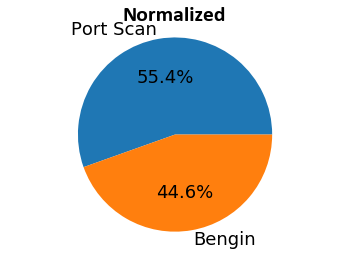

In [25]:
labels = ['Port Scan', 'Bengin']
sizes = [attack, benign]
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct = '%1.1f%%')
ax.axis('equal')
ax.set_title('Normalized', fontweight='bold', fontname='calibri')

In [ ]:
print("PS - LR ", ps_lr_mse, " | NB ", ps_bayes_mse)
print("DDoS - LR ", ddos_lr_mse, " | NB ", ddos_bayes_mse)
print("Normalized PS - LR ", ps_lr_norm_mse, " | NB ", ps_bayes_norm_mse)
print("Normalized DDoS - LR ", ddos_lr_norm_mse, " | NB ", ddos_bayes_norm_mse)

# print("PS - LR ", ps_lr_pred, " | NB ", ps_bayes_pred)
# print("DDoS - LR ", ddos_lr_pred, " | NB ", ddos_bayes_pred)

# print("PS - LR ", ps_lr_ytest.array, " | NB ", ps_bayes_ytest.array)
# print("DDoS - LR ", ddos_lr_ytest.array, " | NB ", ddos_bayes_ytest.array)
# attc_correct = 0
# attc_wrong = 0
# ben_correct = 0
# ben_wrong = 0
# lolol = 0

# for i, x in ps_lr_pred and ps_lr_ytest.array:
#     if x == i:
#         if x == 0:
#             ben_correct = ben_correct + 1
#         elif x == 1:
#             attc_correct = attc_correct + 1
#     elif x != i:
#         if x == 0:
#             ben_wrong = ben_wrong + 1
#         elif x == 1:
#             attc_wrong = attc_wrong + 1
#     else:
#         lolol = 99
    
# print("Correct Attack:", attc_correct)
# print("Correct Benign:", ben_correct)
# print("Wrong Attack:", attc_wrong)
# print("Wrong Benign:", ben_wrong)
# print("RIP WE FUKED UP:", lolol)
# x = 0
# y = 0

# for i in ps_lr_pred:
#     if i == 1:
#         x = x + 1
#     elif i :
#         y = y + 1

# print(x, y)

# a = 0 
# b = 0
# for i in ps_lr_ytest:
#     if i == 1:
#         a = a + 1
#     elif i == 0:
#         b = b + 1

# print(a, b)

In [ ]:
# -------------------------------------------------------------------------------------- Put label at begining
ps_lr = ps_lr[['Label', 'DestinationPort', 'FlowDuration', 'TotalBackwardPackets',
       'TotalLengthofFwdPackets', 'TotalLengthofBwdPackets',
       'FwdPacketLengthMax', 'FwdPacketLengthMin', 'FwdPacketLengthMean',
       'FwdPacketLengthStd', 'BwdPacketLengthMin', 'BwdPacketLengthStd',
       'FlowBytes_s', 'FlowPackets_s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags',
       'BwdHeaderLength', 'FwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthStd', 'PacketLengthVariance', 'FINFlagCount',
       'SYNFlagCount', 'PSHFlagCount', 'ACKFlagCount', 'URGFlagCount',
       'CWEFlagCount', 'Down/UpRatio', 'AveragePacketSize',
       'AvgFwdSegmentSize', 'FwdHeaderLength.1', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
       'SubflowFwdBytes', 'SubflowBwdPackets', 'SubflowBwdBytes',
       'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'ActiveMean', 'ActiveMin', 'IdleMean',
       'IdleStd', 'IdleMax', 'IdleMin']]

ps_bayes = ps_bayes[['Label', 'DestinationPort', 'TotalFwdPackets', 'TotalBackwardPackets',
       'FwdPacketLengthMax', 'FwdPacketLengthMin', 'FwdPacketLengthStd',
       'BwdPacketLengthMax', 'FlowIATMin', 'FwdIATStd', 'FwdIATMin',
       'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags',
       'FwdPackets_s', 'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       'Down/UpRatio', 'AvgFwdSegmentSize', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
       'SubflowBwdPackets', 'act_data_pkt_fwd']]

ddos_lr = ddos_lr[['Label', 'DestinationPort', 'FlowDuration', 'TotalBackwardPackets',
       'TotalLengthofFwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthStd', 'FlowBytes_s',
       'FlowPackets_s', 'FlowIATMean', 'FlowIATStd', 'FlowIATMax',
       'FwdIATTotal', 'FwdIATStd', 'FwdIATMax', 'FwdIATMin', 'BwdIATTotal',
       'BwdIATMean', 'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags',
       'BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'BwdHeaderLength',
       'FwdPackets_s', 'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'ECEFlagCount', 'Down/UpRatio',
       'AveragePacketSize', 'AvgFwdSegmentSize', 'AvgBwdSegmentSize',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
       'SubflowFwdBytes', 'SubflowBwdBytes', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
       'ActiveMean', 'ActiveMin', 'IdleMean', 'IdleMax', 'IdleMin']]

ddos_bayes = ddos_bayes[['Label', 'TotalBackwardPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowIATMean', 'FlowIATStd', 'FlowIATMax', 'FwdIATTotal', 'FwdIATMean',
       'FwdIATStd', 'FwdIATMax', 'BwdIATMax', 'FwdPSHFlags', 'BwdPSHFlags',
       'FwdURGFlags', 'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength',
       'BwdPackets_s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       'Down/UpRatio', 'AveragePacketSize', 'AvgFwdSegmentSize',
       'AvgBwdSegmentSize', 'FwdHeaderLength.1', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate', 'SubflowFwdPackets',
       'SubflowBwdPackets', 'Init_Win_bytes_forward', 'act_data_pkt_fwd',
       'min_seg_size_forward', 'ActiveMean', 'ActiveMax', 'ActiveMin',
       'IdleMean', 'IdleStd', 'IdleMax', 'IdleMin']]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

for col in ps_lr:
    sorted_nb = ps_lr.groupby(['Label'])[col].median().sort_values()
    chart = sns.boxplot(
        x = ps_lr['Label'], 
        y = ps_lr[col], 
        order = list(sorted_nb.index)
    )

    chart.set_xticklabels(
        chart.get_xticklabels(),
        rotation = 90)
    plt.show()

In [ ]:
corr = ps_lr.corr()
plt.figure(figsize=(79, 79))
heatMap = sns.heatmap(
    corr,
    vmin = -1, vmax = 1, center = 0,
    annot = True,
    cmap = sns.diverging_palette(20, 220, n=200),
    square = True
)

In [ ]:
corr = ddos_lr.corr()
plt.figure(figsize=(79, 79))
heatMap = sns.heatmap(
    corr,
    vmin = -1, vmax = 1, center = 0,
    annot=True,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)